The data hosted by iAtlas is available through an API.



In [1]:
# git clone the notebook repo to get this file #
source('https://raw.githubusercontent.com/CRI-iAtlas/iatlas-notebooks/general_db_query/functions/notebook_functions.R')
# or if you have the iatlas notebooks repo locally, you can source('functions/notebook_functions.R')
library_setup()

Loading required package: magrittr

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr


Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract


Loading required package: ggplot2

Loading required package: iatlasGraphQLClient



# Exploring the datasets and features

The iAtlas data is stored in a database that can be queried with functions from the
iatlasGraphQLClient package. We have clinical data, immune features, scores of
predictors of response to immunotherapy, and quantile normalized gene expression.

You can get more information in iAtlas on[immune features](https://isb-cgc.shinyapps.io/iatlas/?module=datainfo), and our annotation of
[immunomodulators](https://isb-cgc.shinyapps.io/iatlas/?module=immunomodulators) genes.

As a first step, let’s take a look at the available datasets.


In [2]:
# datasets that we have in the iAtlas database
datasets <- iatlasGraphQLClient::query_datasets()
datasets


display,name,type
<chr>,<chr>,<chr>
"Chen 2016 - SKCM, Anti-CTLA4",Chen_CanDisc_2016,ici
"Choueiri 2016 - KIRC, PD-1",Choueiri_CCR_2016,ici
"Gide 2019 - SKCM, PD-1 +/- CTLA4",Gide_Cell_2019,ici
GTEX,GTEX,other
"Hugo 2016 - SKCM, PD-1",HugoLo_IPRES_2016,ici
"IMmotion150 - KIRC, PD-L1",IMmotion150,ici
"IMVigor210 - BLCA, PD-L1",IMVigor210,ici
"Kim 2018 - STAD, PD-1",Kim_NatMed_2018,ici
"Liu 2019 - SKCM, PD-1",Liu_NatMed_2019,ici


Let's count the datasets by type.



In [3]:
table(datasets$type)




analysis      ici    other 
       2       15        1 

Currently there are three types: analysis, ici, and other. Analysis data sets include TCGA and PCAWG data while ici
datasets relate to immune checkpoint inhibitor (ICI) studies. Currently, there is only one 'other' type:
the Genotype-Tissue Expression (GTEx) project which is a resource aimed at healthy normal tissue expression.

In this notebook, we'll take a look at the `analysis` datasets. If you're interested in the immune checkpoint inhibitor data, take a look at our `ici_query_iatlas_data` notebook. The data struucture for both types of dataset are the same, so queries described in this notebook can be used for ICI data, but in the `ici_query_iatlas_data` we show some analysis that are specific to ICI, such as treatment and response to therapy annotations.

As a first step, let's check the TCGA studies that are available. 
Data can be tagged with different descriptive terms which help in finding appropriate data given a particular interest.

In [4]:
tcga_studies <- iatlasGraphQLClient::query_tags_with_parent_tags(parent_tags = "TCGA_Study")
tcga_studies$tag_name


[1] "ACC"  "BLCA" "BRCA" "CESC" "CHOL" "COAD" "DLBC" "ESCA" "GBM"  "HNSC"
[11] "KICH" "KIRC" "KIRP" "LAML" "LGG"  "LIHC" "LUAD" "LUSC" "MESO" "OV"  
[21] "PAAD" "PCPG" "PRAD" "READ" "SARC" "SKCM" "STAD" "TGCT" "THCA" "THYM"
[31] "UCEC" "UCS"  "UVM"

From that list, we might be interested in a particular dataset, for instance 
Kidney Chromophobe which is shortened to KICH.

In order to get the sample IDs associated with that dataset, we use the 
query_dataset_samples function.


In [5]:
kich_samples <- iatlasGraphQLClient::query_tag_samples(parent_tags = "TCGA_Study",tags= c(tag_name = "KICH"))

kich_sampleids <- kich_samples$sample_name

length(kich_sampleids)

head(kich_sampleids)


[1] 65

[1] "TCGA-KL-8323" "TCGA-KL-8324" "TCGA-KL-8325" "TCGA-KL-8326" "TCGA-KL-8327"
[6] "TCGA-KL-8328"

With that query, we see the dataset contains 65 samples.

To get a list of available features, we can visit the web portal, or make a query for them.


In [6]:
# running this function with no parameters will return the entire table.
available_features <- iatlasGraphQLClient::query_features(samples=kich_sampleids)

available_features


name,display,class,order,unit,method_tag
<chr>,<chr>,<chr>,<int>,<chr>,<chr>
age_at_diagnosis,Age At Diagnosis,Clinical,NA,Year,NA
AS,Aneuploidy Score,DNA Alteration,5,NA,CNVR-DDR
B_cells_Aggregate2,B Cells,Immune Cell Proportion - Common Lymphoid and Myeloid Cell Derivative Class,3,Fraction,CIBERSORT
B_cells_Aggregate3,B Cells,Immune Cell Proportion - Differentiated Lymphoid and Myeloid Cell Derivative Class,4,Fraction,CIBERSORT
B_cells_memory,B Cells Memory,Immune Cell Proportion - Original,9,Fraction,CIBERSORT
B_cells_naive,B Cells Naive,Immune Cell Proportion - Original,8,Fraction,CIBERSORT
Ball_Hall,Ball Hall Index,TIL Map Characteristic,11,NA,NA
Ball_Hall_Adjusted,Ball Hall Index - TIL count adjusted,TIL Map Characteristic,15,NA,NA
Banfeld_Raftery,Banfield Raftery Index,TIL Map Characteristic,12,NA,NA


The features table includes:
  
  'name' is the computer-readable name.
  'display' is the human-readable name.
  'class' is the type of feature, Clinical, Immune cell proportions etc.
  'order' 
  'unit' describes the form of the feature values, Fractions, Counts etc.
  'method_tag' indicates what method was used to generate the values.


In order to access the feature values, we'll use the following query-function.
To get a table of clinical values, we'll use the 'feature_classes' parameter.


In [10]:
epic_cafs <- iatlasGraphQLClient::query_feature_values(samples = kich_sampleids, features = 'EPIC_CAFs')

head(epic_cafs)

sample,feature_name,feature_display,feature_value,feature_order,feature_class
<chr>,<chr>,<chr>,<dbl>,<lgl>,<chr>
TCGA-KL-8323,EPIC_CAFs,EPIC CAFs,6.786904e-06,NA,EPIC
TCGA-KL-8324,EPIC_CAFs,EPIC CAFs,1.463917e-02,NA,EPIC
TCGA-KL-8325,EPIC_CAFs,EPIC CAFs,1.119062e-08,NA,EPIC
TCGA-KL-8326,EPIC_CAFs,EPIC CAFs,1.398082e-07,NA,EPIC
TCGA-KL-8327,EPIC_CAFs,EPIC CAFs,1.543153e-02,NA,EPIC
TCGA-KL-8328,EPIC_CAFs,EPIC CAFs,3.902143e-07,NA,EPIC


OK, so we've collected the "EPIC CAFs" (display name) of class "EPIC", a method
for estimating cell content from bulk samples.

To learn more about these features, the portal contains a Data Description,
located at the bottom of the right hand side.

Let's compare these scores to gene expression. To start with, let's look at the list of immunomodulator genes,
and genes by gene set name.


In [11]:
immunomodulators <- iatlasGraphQLClient::query_immunomodulators()
head(immunomodulators)


entrez,hgnc,friendly_name,description,gene_family,gene_function,immune_checkpoint,super_category,publications
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<list>
135,ADORA2A,ADORA2A,It is a popular target in immuno-oncology due to its function of immunosuppressive effects in tumor microenvironment.,Receptor,NA,Inhibitory,Receptor,27249753
383,ARG1,ARG1,"In tumor microenvironment, arginase degrades arginine into urea. Arginine is an important amino acid for immune cell growth, and depletion of it lead to immunosuppression.",Enzyme,Immune suppression,Inhibitory,Other,"19764983, 23890059"
151888,BTLA,BTLA,B and T lymphocyte atttenuator negatively regulates T-cell immune responses.,Immunoglobulin,NA,Inhibitory,Receptor,"20038807, 23890059"
11119,BTN3A1,BTN3A1,NA,Butyrophilins,Activation of γδ T cells,Stimulatory,Co-inhibitor,26449179
11118,BTN3A2,BTN3A2,NA,Butyrophilins,Higher expression leads to increased CD4+ infiltration,Stimulatory,Co-inhibitor,"18398031, 22685580"
6352,CCL5,RANTES,NA,Chemokine,NA,Stimulatory,Ligand,"20233026, 26098609"


In [12]:
gene_sets <- iatlasGraphQLClient::query_genes_by_gene_types()

head(table(gene_sets$gene_type_name)) # the list is long!



                         aDC                 Angiogenesis 
                           4                           38 
Antigen_presenting_machinery          B_cell_PCA_16704732 
                           7                          280 
                     B_cells               Bcell_21978456 
                          32                           24 

Now to access some of the gene expression values for analysis.



In [13]:
gene_vals <- iatlasGraphQLClient::query_gene_expression(samples = kich_sampleids, entrez = immunomodulators$entrez[1:5])



The results are long tables, in order to format them to a wide table, that could 
be used to join to other data values, we can use the tidyverse 


In [14]:
gene_vals_wide <- tidyr::pivot_wider(data=gene_vals, id_cols = 'sample', names_from = 'hgnc', values_from = 'rna_seq_expr', )



We can use dplyr to join these tables by their sample IDs.



In [15]:
df <- dplyr::inner_join(epic_cafs, gene_vals_wide)

head(df)


Joining, by = "sample"


sample,feature_name,feature_display,feature_value,feature_order,feature_class,ADORA2A,ARG1,BTN3A2,BTN3A1,BTLA
<chr>,<chr>,<chr>,<dbl>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TCGA-KL-8323,EPIC_CAFs,EPIC CAFs,6.786904e-06,NA,EPIC,125.6440,0.0000,771.440,430.794,5.1855
TCGA-KL-8324,EPIC_CAFs,EPIC CAFs,1.463917e-02,NA,EPIC,639.7270,0.9398,662.124,402.726,0.4699
TCGA-KL-8325,EPIC_CAFs,EPIC CAFs,1.119062e-08,NA,EPIC,32.0452,0.6676,80.113,193.273,1.6690
TCGA-KL-8326,EPIC_CAFs,EPIC CAFs,1.398082e-07,NA,EPIC,60.8083,0.0000,1565.200,705.970,1.9775
TCGA-KL-8327,EPIC_CAFs,EPIC CAFs,1.543153e-02,NA,EPIC,99.0566,0.0000,555.660,510.377,1.8868
TCGA-KL-8328,EPIC_CAFs,EPIC CAFs,3.902143e-07,NA,EPIC,343.8970,0.0000,492.524,443.589,4.0779


Now we can make plots using the data table.



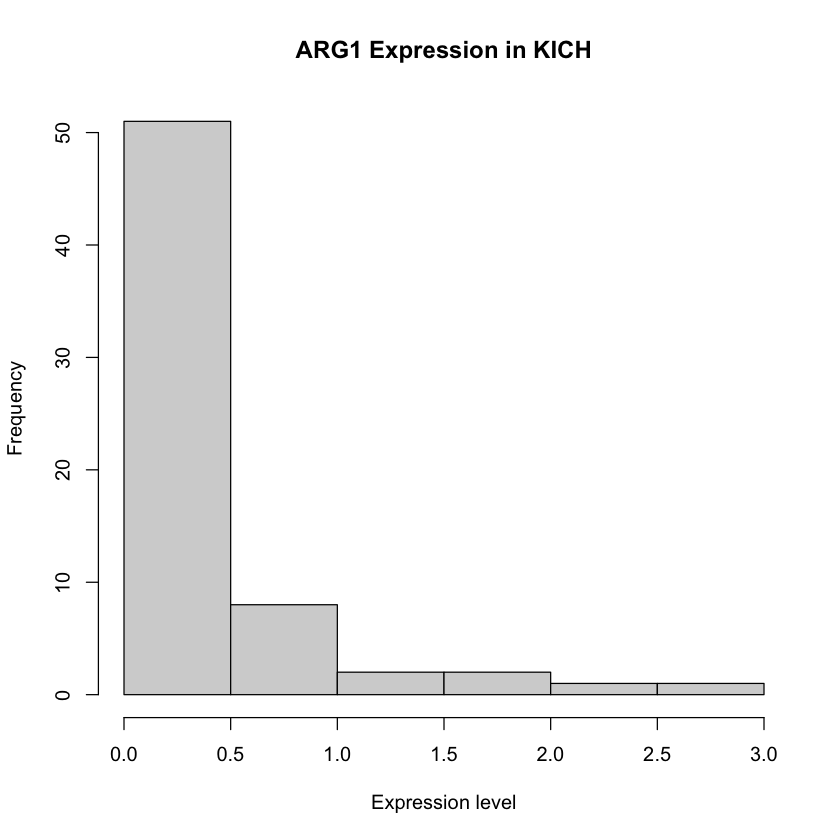

In [16]:
hist(df$ARG1, main = "ARG1 Expression in KICH", xlab = "Expression level")



And we can fit models associating the feature values to gene expression.



In [17]:
m1 <- lm(feature_value ~ ADORA2A + ARG1 + BTN3A2 + BTN3A1 + BTLA, data=df)

m1



Call:
lm(formula = feature_value ~ ADORA2A + ARG1 + BTN3A2 + BTN3A1 + 
    BTLA, data = df)

Coefficients:
(Intercept)      ADORA2A         ARG1       BTN3A2       BTN3A1         BTLA  
  1.554e-02    4.529e-05    5.850e-02   -1.057e-05   -1.063e-05    3.443e-03  


We can plot the model diagnostics.



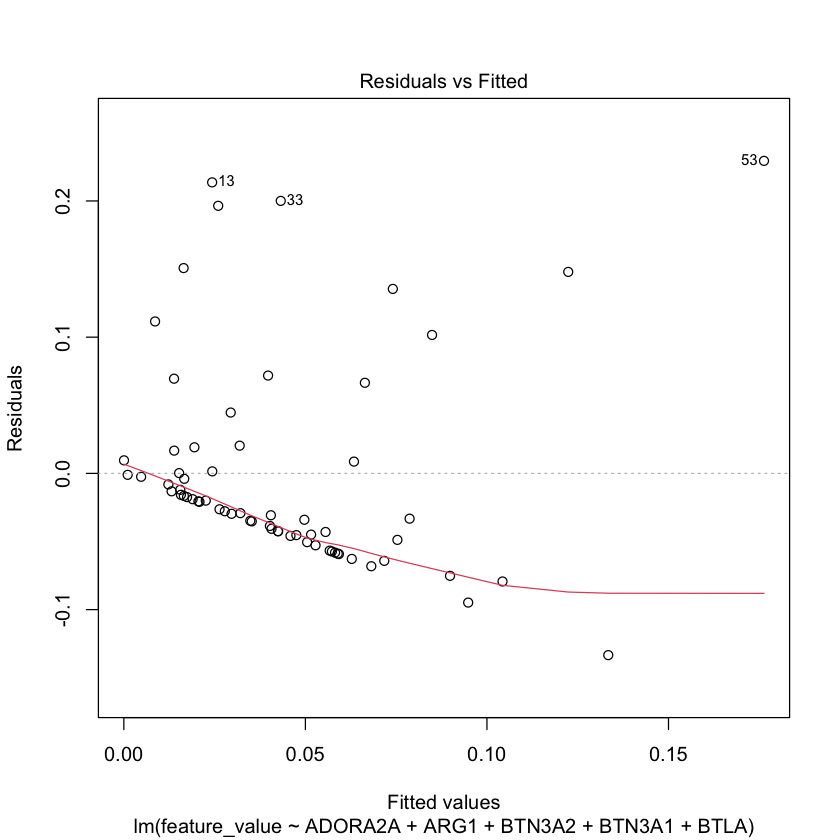

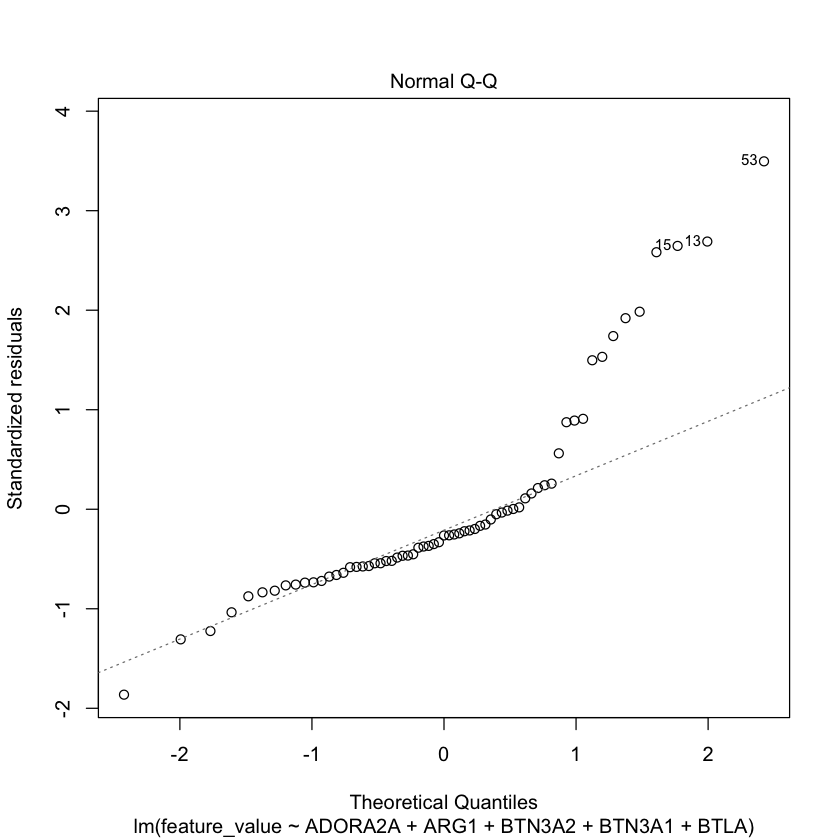

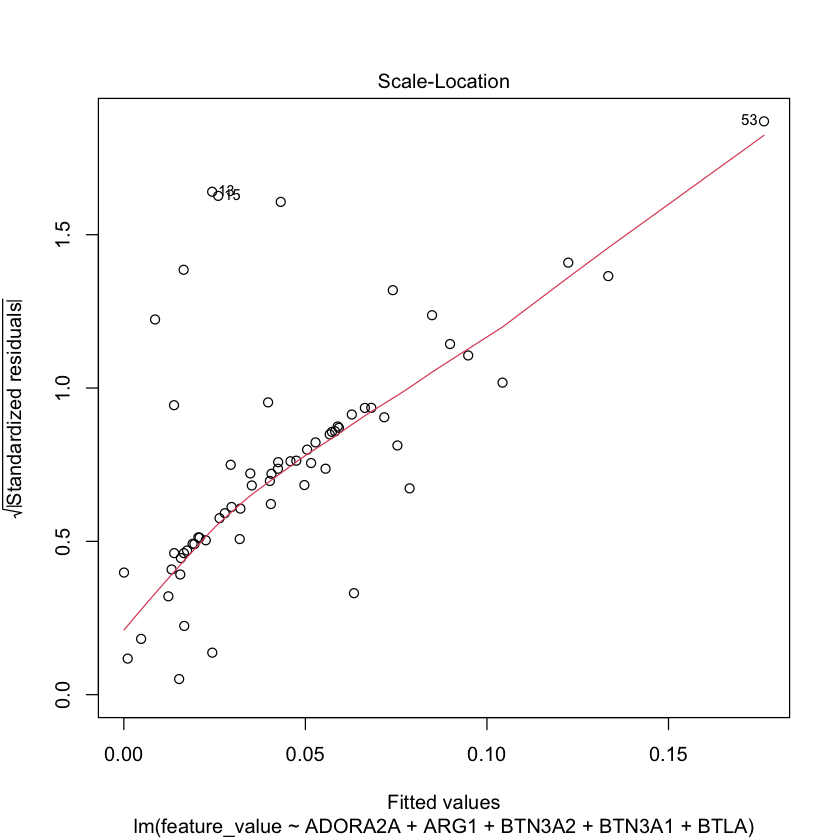

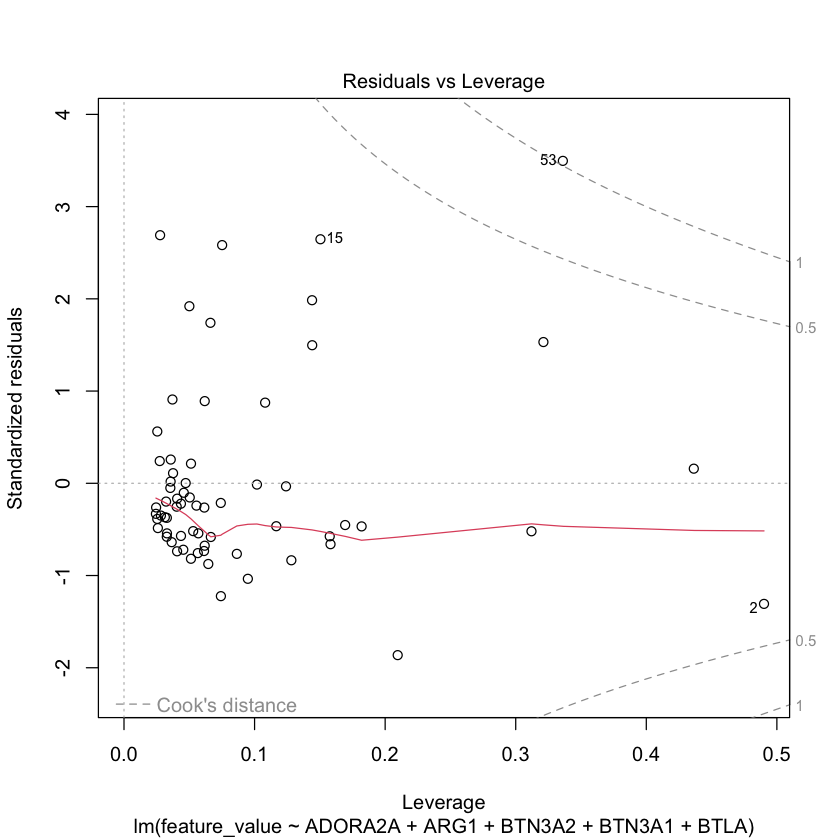

In [18]:
plot(m1)



In [19]:
summary(m1)




Call:
lm(formula = feature_value ~ ADORA2A + ARG1 + BTN3A2 + BTN3A1 + 
    BTLA, data = df)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.133409 -0.045314 -0.020843  0.009588  0.229420 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  1.554e-02  2.643e-02   0.588  0.55875   
ADORA2A      4.529e-05  1.061e-04   0.427  0.67109   
ARG1         5.850e-02  2.000e-02   2.925  0.00488 **
BTN3A2      -1.057e-05  3.872e-05  -0.273  0.78577   
BTN3A1      -1.063e-05  7.817e-05  -0.136  0.89233   
BTLA         3.443e-03  2.115e-03   1.628  0.10889   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.08054 on 59 degrees of freedom
Multiple R-squared:  0.1542,	Adjusted R-squared:  0.08248 
F-statistic: 2.151 on 5 and 59 DF,  p-value: 0.07181


And we can plot (potentially) interesting variable relations.



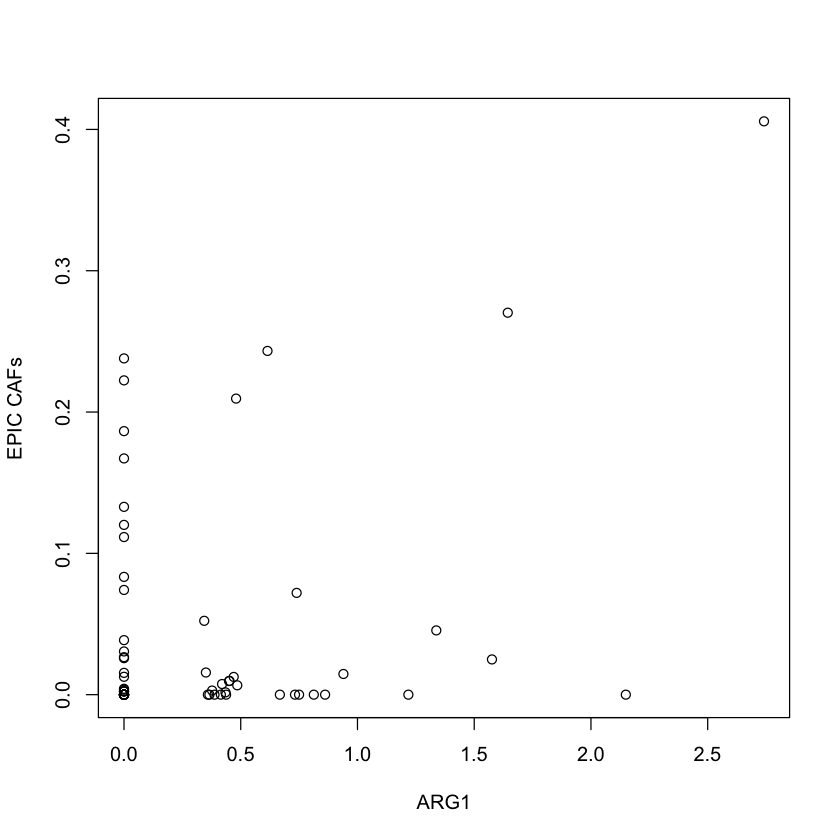

In [20]:
plot(x=df$ARG1, y=df$feature_value, xlab="ARG1", ylab="EPIC CAFs")



Please see https://cri-iatlas.org and let us know if we can help!

